# Setting 


- Trade Date: 2023-09-01  
- Maturity: 2025-08-31  
- Goal: Find appropriate coupon rate
- Notion Defination:    
    $$
    F_{(t, T)}:= S_t\times e^{(r - q) \times (T-t)}, \text{ which is forward price at time }t\text{ with maturity }T.\\
    r_{(t, T)}:= \text{ Time}_t\to\text{Time}_T\text{ risk-free rate p.a. with continuous compounding.}\\
    q_{(t, T)}:= \text{ Time}_t\to\text{Time}_T\text{ dividend yield p.a. with continuous compounding.}\\
    C := \text{ the mid price of the call option.}\\
    P := \text{ the mid price of the put option.}\\
    $$

In [6]:
# import necessary libraries
import os
os.chdir('../')
import pandas as pd

# import class object under Code folder
from derivative_pricing.data_cleaning import data_cleaning
from derivative_pricing.implied_vol import BS_implied_vol
from derivative_pricing.fit_bs import fit_BS

# Volatility Surface


## Data Collection



- Option: 
  - Underlying: 
    - SPX option
    - HSI option
    - Nikkei option
  - Spot option price: 2023-09-01
- Index price
- Index correlation
- Interest rate
- Dividend yield


## Data Cleaning



- delete unnecessary rows and columns
- breakdown option ticker 
- change expiration date format
- only use SPX data not SPXW data
- keep options with certain expiration date which have more than 10 implied volatility
- use the mid price of bid and ask as the option price
- reusable variables
  - `option_data_{index}`
  - `{index}_data`
  - `option_price_{index}`

In [7]:
%run derivative_pricing/data_cleaning.py

Exception: File `'derivative_pricing/data_cleaning.py'` not found.

## Interest Rate, Dividend Yield, & Forward Price  



### Choice 1: Forward Moneyness
> **use put-call parity to get implied interest rate and implied forward price**  
- Put-Call Parity:
    $$
    \begin{align}
    C-P & = S_0e^{-q_{(0, T)}T}-Ke^{-r_{(0, T)}T} \\
        & = e^{-r_{(0, T)}T}(S_0e^{(r_{(0, T)}-q_{(0, T)})T}-K)& \\
        & = e^{-r_{(0, T)}}(F_{(0, T)}-K)\\
        & = -e^{-r_{(0, T)}}K + F_{(0, T)}e^{-r_{(0, T)}}\\
    \end{align}\\
    $$

- Linear Regression:  
    $$
    y:= C-P, \quad x:= K, \quad y = ax + b\\
    \therefore \quad a = -e^{-r_{(0, T)}}, \quad b = F_{(0, T)}e^{-r_{(0, T)}}\\
    \Rightarrow \quad r_{(0, T)} = -\ln\left(\frac{1}{a}\right), \quad F_{(0, T)} = -\frac{b}{a}\\
    $$  
  ![put-call parity](./Public/Plot/Put_call_parity/SPX_2023-09-15.png)
- reusuable variables
  - `implied_params`

In [9]:
implied_params = BS_implied_vol(option_price).parity_implied_params(option_data, plot_parity=False)
display(implied_params.head())
# BS_implied_vol(option_price_spx).plot_ir(implied_params)
# BS_implied_vol(option_price_spx).plot_fwd(implied_params)

,Index,Expiry,implied_ir,implied_fwd
0,SPX,2023-09-15,0.051018,4521.108973
1,SPX,2023-10-20,0.064610,4541.316310
2,SPX,2023-11-17,0.051196,4555.638916
3,SPX,2023-12-15,0.055533,4570.635823
4,SPX,2024-01-19,0.056832,4594.397578


### Choice 2: Spot Moneyness 
> use IR and dividend yield from Bloomberg
  - Spot moneyness: $\ln{\frac{K}{S_t}}, \quad S_t:= \text{stock price at time }t$  
  - Easy to get spot price at time t, e.g. today, we are at 2024-01-01, then $S_t = S_{2024-01-01}$, which can be directly calculated by Simulation


## Black-Scholes Model Implied Vol



- Find BS implied volatility
  - Black-Scholes model using forward price, the formula is:
    
    $$
    \begin{align}
    C(t) & = e^{-r_{(t,T)}(T-t)}(F_{(t, T)}\Phi(d_1)-K\Phi(d_2)) \\
    P(t) & = e^{-r_{(t, T)}(T-t)}(K\Phi(-d_2)-F_{(t, T)}\Phi(-d_1))\\
    \displaystyle\text{where }d_1 &= \frac{\ln(\frac{F_{(t, T)}}{K})+\frac{1}{2}\sigma^2(T-t)}{\sigma\sqrt{T-t}},\\
    d_2 &= d_1-\sigma\sqrt{T - t}, \\ 
    \text{and }F_{(t, T)}  &:=S_0e^{(r_{(t, T)}-q_{(t, T)})(T-t)}
    \end{align}
    $$
    $$
    \phi() \text{ is the standard normal pdf} \\
    $$
    
  - Use bisection method to get the implied volatility.   
    $$
      \sigma_{implied}(F_{(0, T)}, K, T, r, c) = \sigma_{implied}(F_{(0, T)}, K, T, r, p)\\
    $$
  ![spx rough implied vol scatter](./Public/Plot/Rough_iv/SPX_rough_iv.png)

In [10]:
%run Code/implied_vol.py

1


- Fit the implied volatility curve for each maturity
  - Find Forward Moneyness, for each maturity, the forward price is different.
    $$
      \text{Forward Moneyness} = \ln\left(\frac{K}{F_{(t, T)}}\right)\\
    $$
  - For the same maturity, fit the implied volatility curve against spot moneyness using function below:
    - option 1: similar to tanh function
      $$
      \sigma(x)^2 = \sigma_{atmF}^2 + \delta\displaystyle\left(\frac{\tanh(\kappa x)}{\kappa}\right) + \frac{\gamma}{2}\left(\frac{\tanh(\kappa x)}{\kappa}\right)^2,\quad
      \text{where }x = \displaystyle\ln\left(\frac{K}{F_{(0, T)}}\right)
      $$
    - option 2: similar to sigmoid function
  - Find $\sigma_{atmF}$
  - Use optimization to find $\delta, \kappa, \gamma$  
  ![spx BS implied vol curve](./Public/Plot/Implied_vol/SPX_BS_IV_Curve.png)

- Connect all implied volatility curve to surface using cubic spine  
  ![spx BS implied vol surface](./Public/Plot/Volatility_surface/SPX_BS_IV_Surface.png)


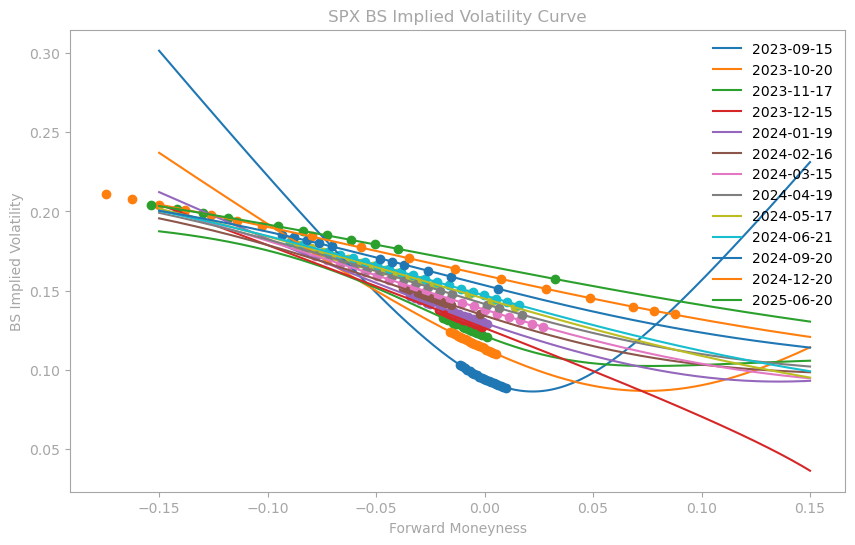

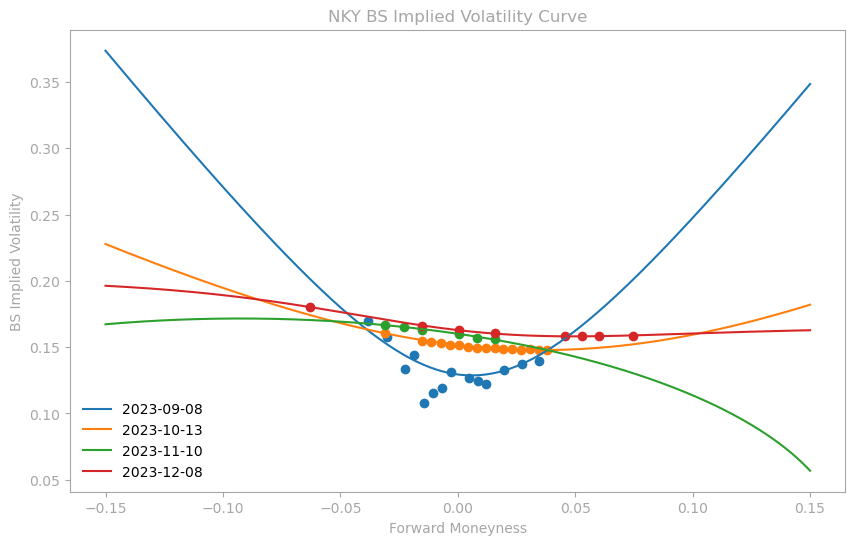

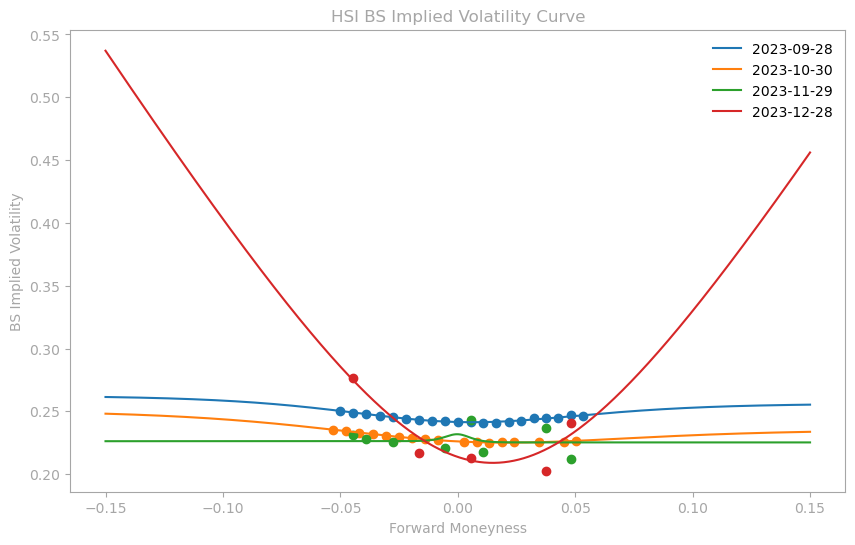

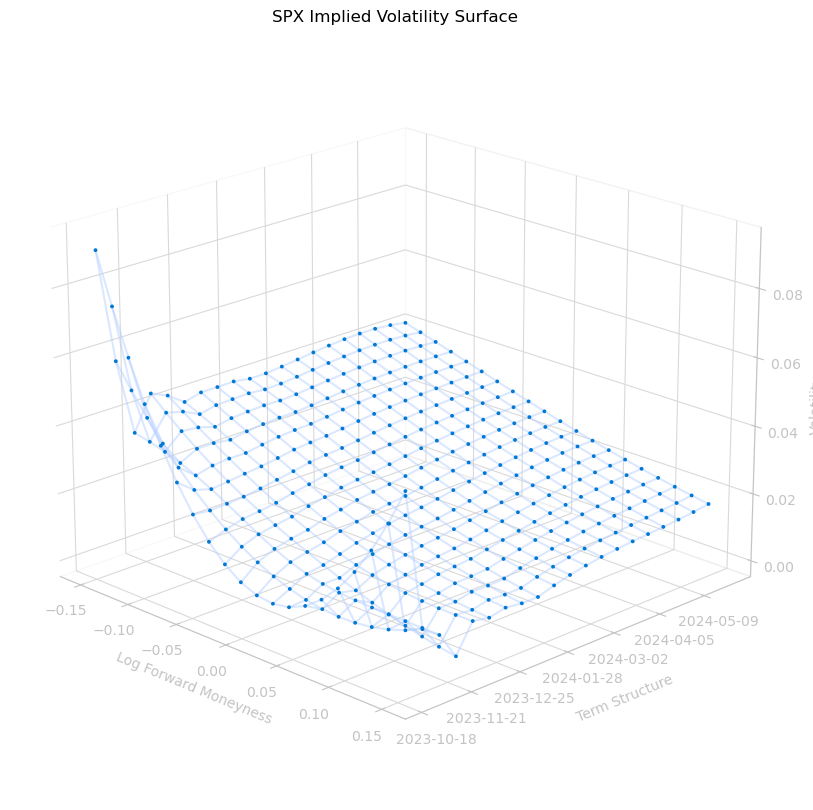

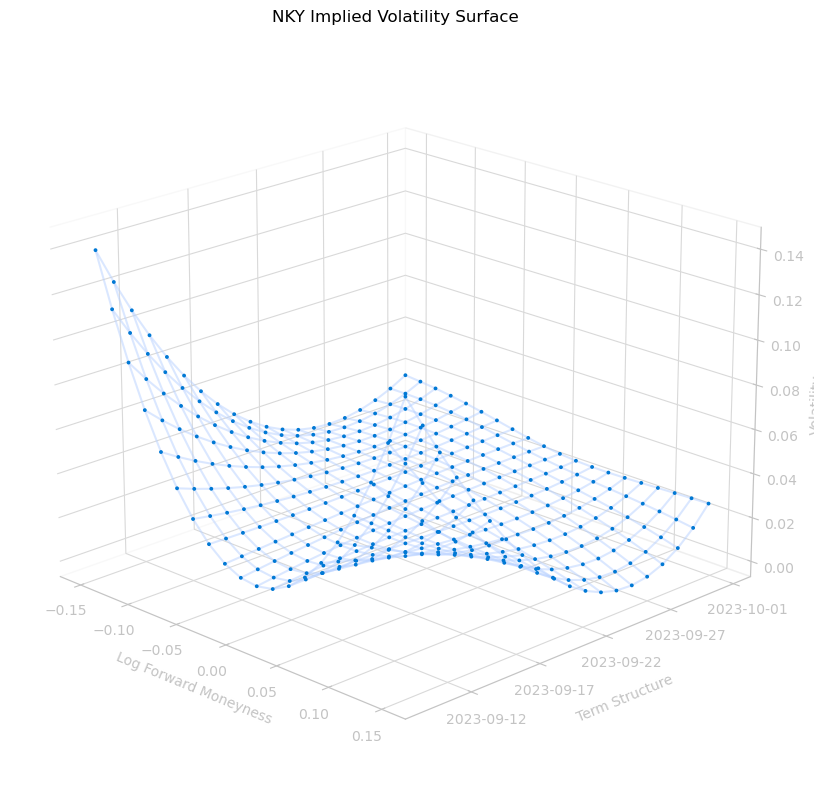

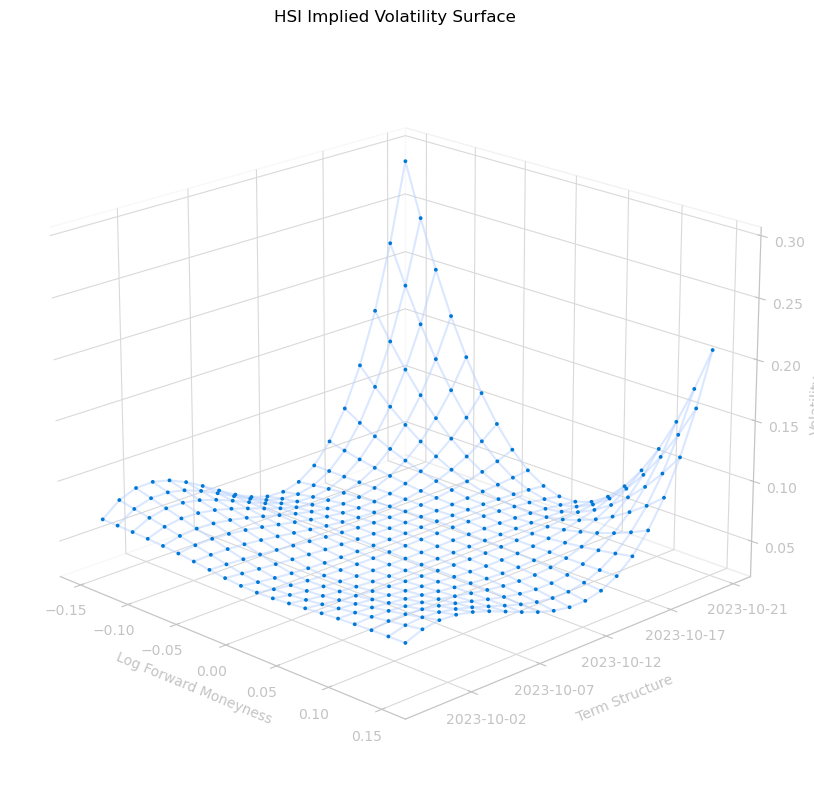

In [11]:
%run Code/fit_bs.py

## Local vol


- Convert BS Implied Volatility Surface to Local Volatility Surface
- use Dupire's formula to calculate the local volatility for each option
  $$
  \frac{\partial w}{\partial T} = v_L \left\{1 - \frac{y}{w}\frac{\partial w}{\partial y} + \frac{1}{4}\left(-\frac{1}{4}-\frac{1}{w}+\frac{y^2}{w^2}\right)\left(\frac{\partial w}{\partial y}\right)^2+\frac{1}{2}\frac{\partial^2 w}{\partial y^2}\right\}\\
  \text{where }w:=\text{ Black-Scholes implied variance},\quad y:= \ln\left(\frac{K}{F_T}\right), \quad v_L:=\text{ local volatility}
  $$

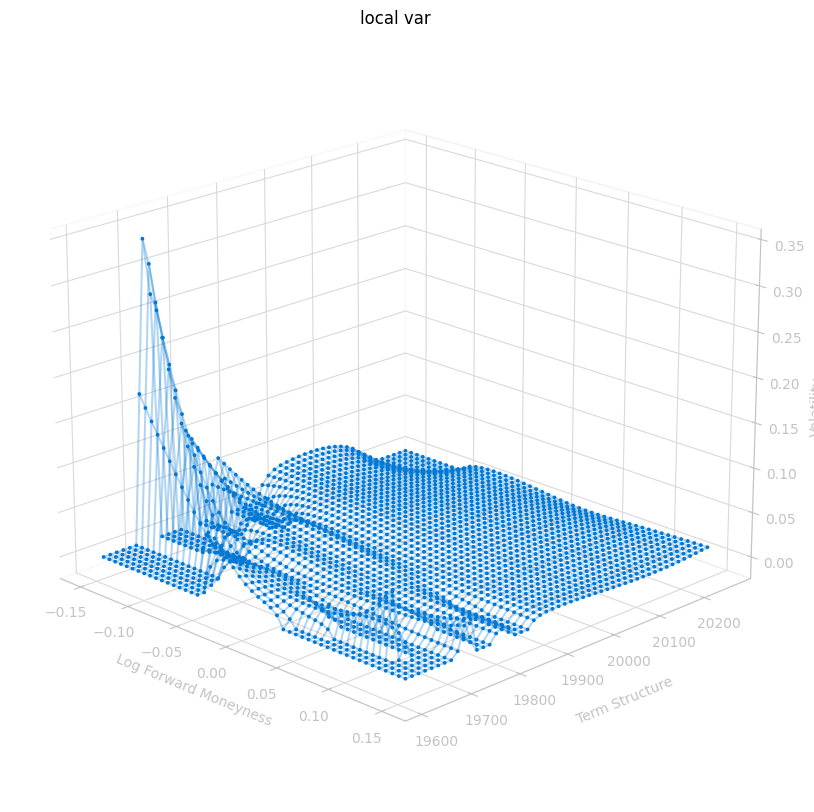

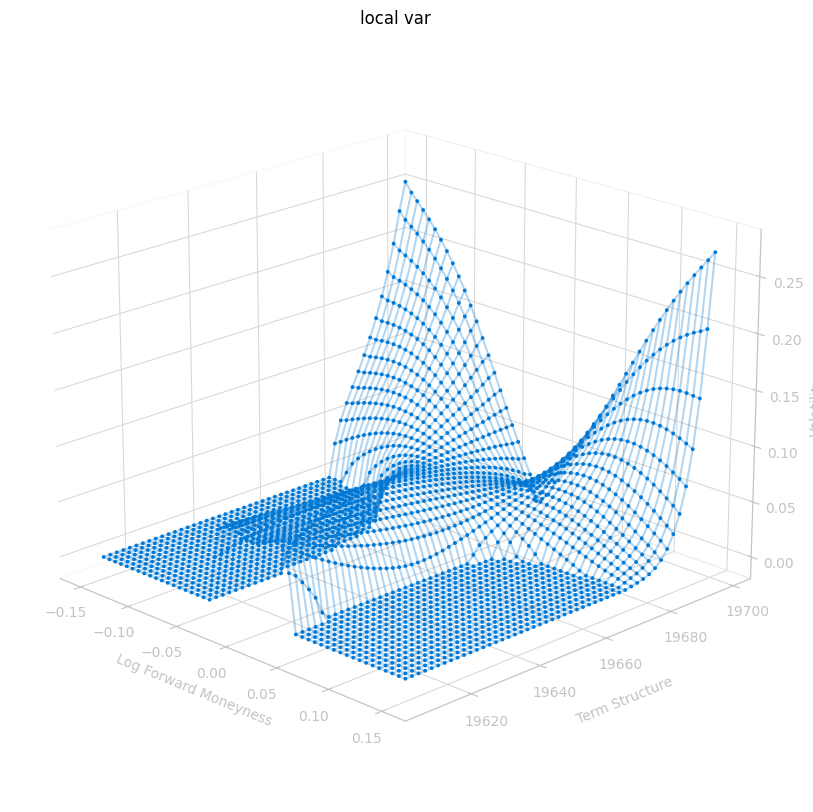

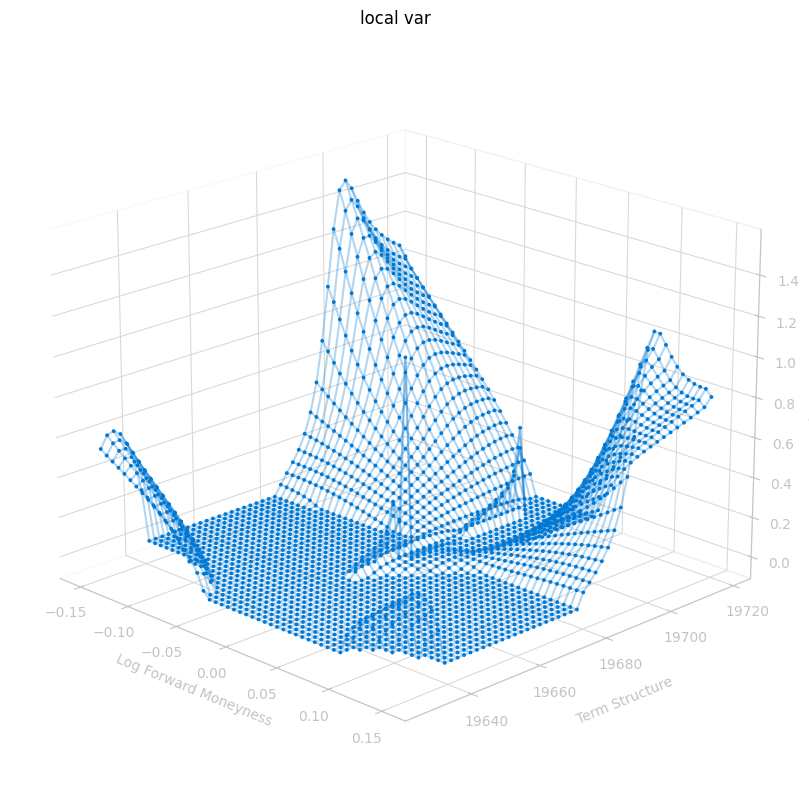

In [1]:
%run Code/local_vol.py

In [2]:
display(local_vol_surface_spx.head())

,19615.000000,19628.142857,19641.285714,19654.428571,19667.571429,19680.714286,19693.857143,19707.000000,19720.142857,19733.285714,...,20140.714286,20153.857143,20167.000000,20180.142857,20193.285714,20206.428571,20219.571429,20232.714286,20245.857143,20259.000000
-0.150000,0.0,0.0,0.0,0.0,0.0,0.0,0.168023,0.336337,0.273799,0.0,...,0.024396,0.018202,0.005994,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.143878,0.0,0.0,0.0,0.0,0.0,0.0,0.154851,0.311101,0.258183,0.0,...,0.023012,0.017499,0.007610,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.137755,0.0,0.0,0.0,0.0,0.0,0.0,0.142254,0.271044,0.230272,0.0,...,0.021585,0.016777,0.008854,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.131633,0.0,0.0,0.0,0.0,0.0,0.0,0.129762,0.234827,0.202850,0.0,...,0.020351,0.016211,0.009897,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0.125510,0.0,0.0,0.0,0.0,0.0,0.0,0.117365,0.202245,0.176800,0.0,...,0.019311,0.015791,0.010791,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Thought on Local vol transform
- Have tried to transfrom the BS implied vol to local vol
- But not sure whether it is correct, since My function only use maturity time, instead of current time point
- you may take it as a reference
- you may refer to the local_vol_trial file for reference
  - $ \displaystyle  y  = \log(\frac{K}  {F_{T}})$
  - $ \displaystyle  w(S_0,K,T) = \sigma_{BS}^2(S_0,K,T)T$
  - $ Y = forward \_moneyness(K,S0,T + time\_steps)$
  - $ \sigma_{BS} = vol\_surface\_to\_vol(\log{\frac{K}{F_t}},T) $
  - $ w = (vol \space surface \space to\space vol(\log{\frac{K}{F_t}},T + time\_steps) ^2 ) * T $

# Simulation


The simulation can be broken down into three steps:
1. Simulate the three underlying indices NKY, SPX and HSI using Monte Carlo Simulation.
2. Calculate the expected value of the autocallable based on the simulated laggard prices.
3. Find the target coupon strike.

Here, the steps will be explained as briefly as possible.

## Monte Carlo Simulation of Multiple Underlyings
First, we simulate the indices by setting up a Monte Carlo Simulation. Their price dynamics follow the Geometric Brownian Motion (GBM).

### Geometric Brownian Motion
$$
dS_{1,t} = (r-q_1) S_{1,t} dt + \sigma S_{1,t} dZ_{1,t}\\
dS_{2,t} = (r-q_2) S_{2,t} dt + \sigma S_{2,t} dZ_{2,t}\\
dS_{3,t} = (r-q_3) S_{3,t} dt + \sigma S_{3,t} dZ_{3,t}
$$

### Stock Price Dynamics
$$
S_{t + \Delta t} = S_t exp(\nu \Delta t + \sigma \sqrt{\Delta t}\epsilon_i) \\
\text{where } \nu = (r - q) - \frac{1}{2} \sigma^2.
$$

  
For the implementation, we need to use correlated Wiener processes ($Z_t$) instead of the normal Wiener processes ($W_t$). They are generated by using the correlation matrix of the underlying indices and the Cholesky decomposition.

### Correlation Matrix
$$
\rho_Z = \begin{bmatrix} 1 & \rho_{12} & \rho_{13} \\ \rho_{12} & 1 & \rho_{23} \\ \rho_{13} & \rho_{23} & 1 \end{bmatrix}
$$ 

### Cholesky Decomposition
$$
    \begin{align}
    Z_1 & = W_1 \\
    Z_2 & = \rho_{12} W_1 + \sqrt{1 - p^2_{12}} W_2 \\
    Z_3 & = \rho_{13} W_1 + \frac{\rho_{23} - \rho_{12} \rho_{13}}{\sqrt{1 - \rho^2_{12}}} W_2 + \sqrt{1 - \rho^2_{12} - \frac{(\rho_{23} - \rho_{12} \rho_{13})^2}{1 - \rho^2_{12}}} W_3
    \end{align}\\
 ~\\ 
    \begin{bmatrix}
    Z_1 \\
    Z_2 \\
    Z_3
    \end{bmatrix} = 
    \begin{bmatrix} 
    1 & 0 & 0 \\ 
    \rho_{12} & \sqrt{1 - p^2_{12}} & 0
    \\ \rho_{13} & \frac{\rho_{23} - \rho_{12} \rho_{13}}{\sqrt{1 - \rho^2_{12}}} & \sqrt{1 - \rho^2_{12} - \frac{(\rho_{23} - \rho_{12} \rho_{13})^2}{1 - \rho^2_{12}}} 
    \end{bmatrix}
    \begin{bmatrix}
    W_1 \\
    W_2 \\
    W_3
    \end{bmatrix}
$$
  
where the 3-by-3 matrix is the Cholesky factor of $\rho_{Z}$.

To put this step simply, the goal is to generate some $Z_t$'s such that they are the linear combinations of the $W_t$'s. We can make some $Z_t$'s that are sort of correlated to one another instead of deploying three independent and completely uncorrelated $W_t$'s.

After preparing the necessary parameters, we can launch the Monte Carlo Simulation and simulate the three indices:

(Here we only show four simulations)

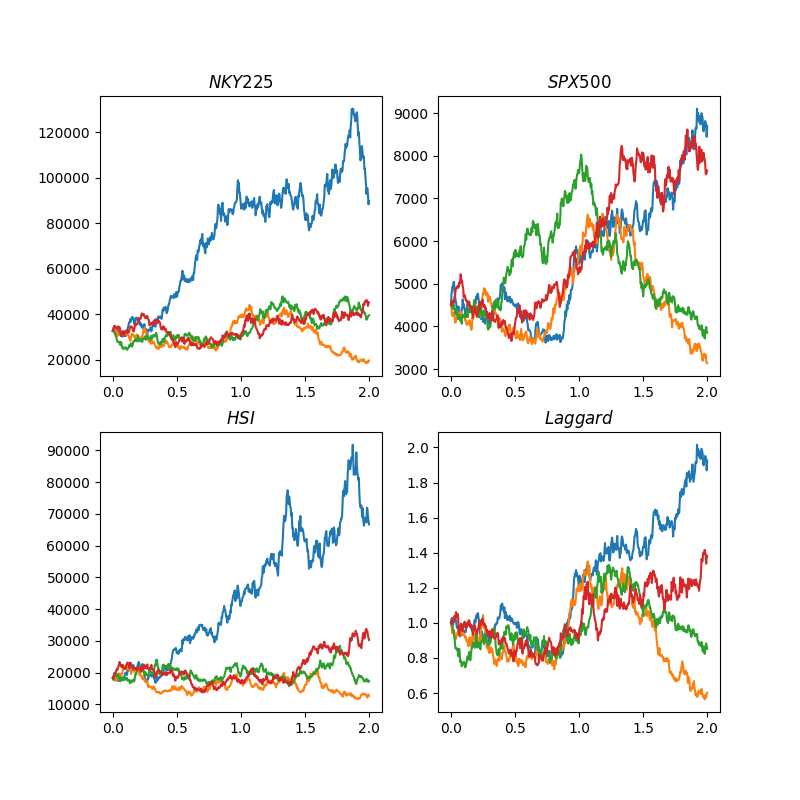

where the laggard underlying is computed using this formula:
$$ 
min( \frac{S_{t,NKY}}{S_{0,NKY}}, \frac{S_{t,SPX}}{S_{0,SPX}}, \frac{S_{t,HSI}}{S_{0,HSI}})  
$$
  
On the bottom-left chart, you can observe that the laggard underlying paths always follow those paths of the worst-performing index among the three indices. This is in line with our laggard formula.
  
  
Obtaining the simulated laggard underlying paths. We can proceed to the next step to calculate the note expected value.


## Expected Value of Autocallable Note

Three are three possible payoffs for the autocallable, depending on the occurrence of the following events:
- Knock-out event
- Knock-in event
- No event

### Knock-Out Event

In any obervation dates (every 6 months), if the laggard underlying exceeds the knock-out strike (110%), the note will expire immediately. The buyer will receive 100% of the note denomination plus the coupons paid upto that observation date inclusive. Therefore, the payoff formula is:
  
  
$$
\begin{align} N_{t=0} & = \text{Coupon Payments + Note Denomination} \\
N_{t=0} & = \sum^{k}_{i=1} (C_i e^{-(r-q) \frac{126}{252} i}) + N_D e^{-(r-q) \frac{126}{252} k} \end{align} 
$$

where
- $N_{T=0}$ is the present value of the note,
- $i$-th is the observation date,
- $i$-th is the observation date when the knock-out event is triggered,
- $C_i$ is the coupon payment,
- and $N_D$ is the note denomination.

For example, if the knock-out event is triggered on the $3^{rd}$ observation date, the buyer will receive coupons $C_1$, $C_2$, $C_3$ and the note denomination $N_D$. Be reminded that the coupons and note principal are paid out at different points of time. Hence, they need to be discounted accordingly in order to find the present value of the note.

Notice that we have not yet discussed the calculation of the coupon payments. This will be addressed in the later section.

### Knock-In Event

In any point of time, if the laggard underlying is below the knock-in strike (50%), at the maturity the buyer will receive the sum of all the coupons and a final redemption amount, which is calculated as the following:
  
  
$$
    \begin{align}
    N_{t=T} & = \text{Coupon Payments} + \text{Final Redemption Amount} \\
    N_{t=T} & = \sum^{4}_{i=1} (C_i) e^{(r-q) (T - \frac{126}{252} i)} + N_D \times min( \text{100\%}, \frac{Final Closing Price Of Laggard}{Spot Price Of Laggard})
    \end{align}
$$
  
where $N_{t=T}$ is the note value at the maturity,  and $N_{D}$ is the note denomination. 

### No Event

If the laggard underlying does not trigger both the knock-out event on the observation dates and the knock-in event anytime during the life of the autocallable, the buyer receives a no-event payoff. Following the knock-in event, the calculation of this payoff is simple:
  
  
$$
    \begin{align}
    N_{t=T} & = \text{Coupon Payments} + \text{Note Denomination} \\
    N_{t=T} & = \sum^{4}_{i=1} (C_i) e^{(r-q) (T - \frac{126}{252} i)} + N_D
    \end{align}
$$
  
where $N_{t=T}$ is the note value at the maturity,  and $N_{D}$ is the note denomination.

### Coupon Payment

One important component in the note payoff computation is the calculation of the coupon payments. If the laggard underlying exceeds a certain threshold on the observation dates, the buyer will receive a coupon at the maximum coupon rate (10%), otherwise he/she will receive a coupon at the minimum coupon rate (5%). Hence, the coupon payment is as follows:
  
$$
C_i =   \left\{
\begin{array}{ll}
      N_D \times Max Coupon Rate, & Laggard >= CS \\
      N_D \times Min Coupon Rate, & Laggard < CS \\
\end{array} 
\right.  
$$
  
Now we have mapped out all the possible payoffs for the autocallable. With one more component, we can compute the note expected value based on our laggard underlying paths simulated in the Monte Carlo Simulation.
  
  
          
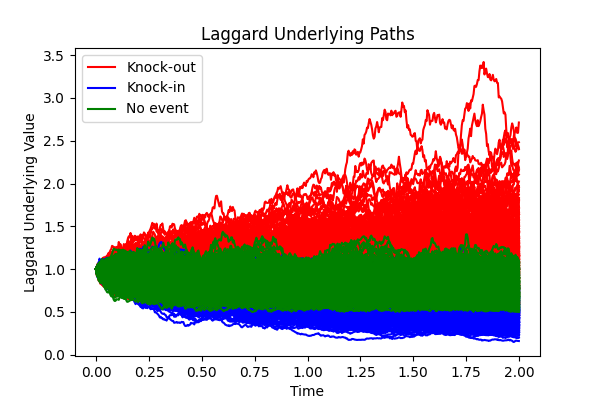

The missing component is the coupon strike, which we do not know from the outset. We need to input a random coupon strike to see how the expected note value evolves. Therefore, the final section will discuss how we can map out the coupon strike versus the expected note value, and hence find the specific coupon strike that we need.

## 3. Finding Target Coupon Strike

The final section is easy and straight-forward. Now we have obtained the function of which the input is the coupon strike and the output is the expected note value. Since the function cannot be solved analytically, we will use the Bisection method to find out the solution.

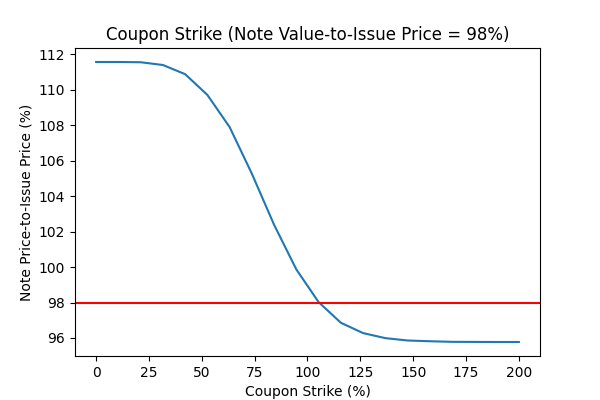

You can observe that when the coupon strike goes up, the note value goes down. This aligns with the logical intuition that the higher the coupon strike, the less likely coupon payments are paid out at the maximum coupon rate, the lower the note value.

In our example, the target coupon strike is 105.47%. This is the final result that we need.

For the algorithm of the Bisection method, please refer to any credible textbooks of mathematics / computer science or related subjects for detailed explanation. The sources are abundant and we do not want to bore our audience with a tedious lecture on this topic.

For the details of the coding process, please contact me (Leo) so we could discuss it directly.
<br>
<br>
_[This is the end of the simulation section.]_

# Some Brainsotrming

## Retrieve Index Price  
- Weiener Process, 3 correlated Weiener Process
- Get volatility from volatility surface
- Simulate index price
  - $ \displaystyle S_t=S_0e^{\left(r-\frac{\sigma^2}{2}\right)}$


- Forward moneyness: 
  $$
  \ln{\left(\frac{K}{F_{(t, T)}}\right)}\\
  $$  
  - How to get $F_{(t, T)}$?
    - $F_{(t, T)} = S_t\times e^{(T-t)\times (r - q)}$
    - $F_{(t, T)} = \displaystyle S_t \frac{S_0 e^{T\times (r-q)}}{S_0 e^{t\times (r-q)}} = S_t \frac{F_{(0, T)}}{F_{(0, t)}},\\ \text{where } S_t\text{ can be directly calculated by Simulation. } F_{(0, t)}, \text{ and }F_{(0, T)} \text{ can be get at time }0.$


  - $F_{(t, T)} = S_t\times e^{(T-t)\times (r - q)}, \quad \text{where }r\text{ is the risk-free rate, }q\text{ is the dividend yield}$
  - $F_{(t, T)} = \displaystyle S_t \frac{S_0 e^{T\times (r-q)}}{S_0 e^{t\times (r-q)}} = S_t \frac{F_{(0, T)}}{F_{(0, t)}},\quad \text{where } S_t\text{ can be directly calculated by Simulation. } F_{(0, t)}, \text{ and }F_{(0, T)} \text{ can be get at time }0.$


# To Do

- why there are so little dates in nky and hsi? can I change it?